## 1.(a).i. Trees & Tree-Based Ensembles_Hyperparameters

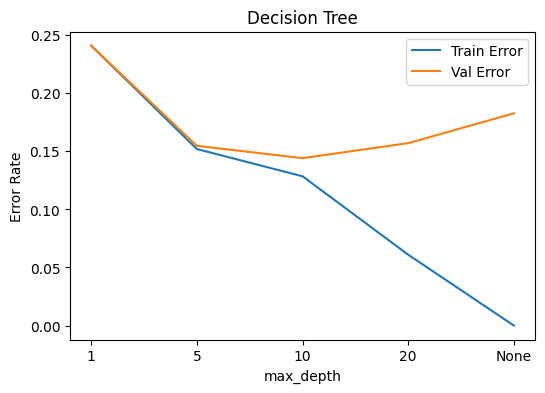

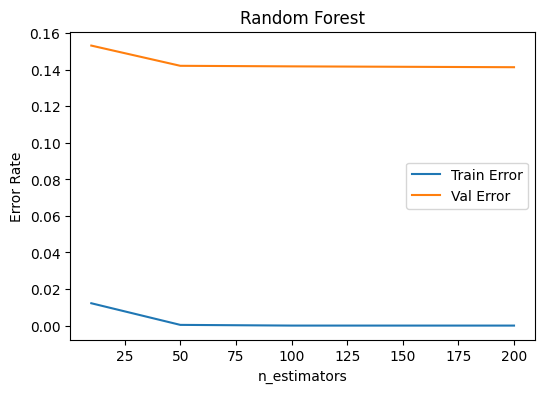

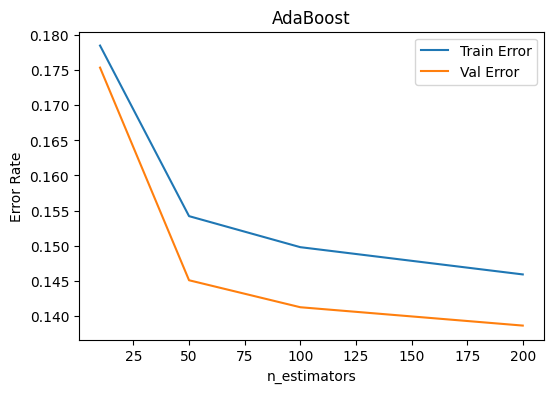

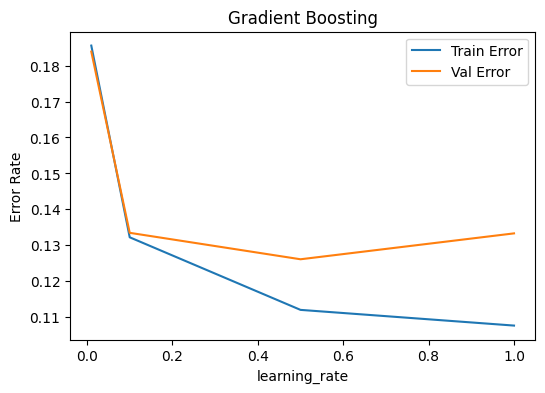

In [1]:
# Part 1(a)(i)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import time

# Load and preprocess data
tcols = ['age','workclass','fnlwgt','education','education_num','marital_status',
         'occupation','relationship','race','sex','capital_gain','capital_loss',
         'hours_per_week','native_country','income']
train = pd.read_csv('adult.data', names=tcols, na_values=' ?', skipinitialspace=True)
test = pd.read_csv('adult.test', header=0, names=tcols, na_values=' ?', skipinitialspace=True)
train.dropna(inplace=True)
test.dropna(inplace=True)
test['income'] = test['income'].str.rstrip('.')

# One-hot encoding
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_cols = train.select_dtypes('object').columns.drop('income')
enc.fit(train[cat_cols])

def preprocess(df):
    X_num = df.select_dtypes(include=['int64','float64']).drop(columns=['education_num'])
    X_cat = enc.transform(df[cat_cols])
    X = np.hstack([X_num.values, X_cat])
    y = (df['income'] == '>50K').astype(int).values
    return X, y

X_train_full, y_train_full = preprocess(train)
X_test, y_test = preprocess(test)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# Plot helper
def plot_curve(name, param, vals, train_err, val_err):
    plt.figure(figsize=(6,4))
    plt.plot(vals, train_err, label='Train Error')
    plt.plot(vals, val_err, label='Val Error')
    plt.xlabel(param); plt.ylabel('Error Rate')
    plt.title(name); plt.legend(); plt.show()

# Decision Tree overfit
depths = [1,5,10,20,None]
train_e, val_e = [], []
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=0)
    clf.fit(X_train, y_train)
    train_e.append(1-accuracy_score(y_train, clf.predict(X_train)))
    val_e.append(1-accuracy_score(y_val, clf.predict(X_val)))
plot_curve('Decision Tree', 'max_depth', ['1','5','10','20','None'], train_e, val_e)

# Random Forest overfit
ests = [10,50,100,200]
train_e, val_e = [], []
for n in ests:
    clf = RandomForestClassifier(n_estimators=n, max_depth=None, max_features='sqrt', random_state=0)
    clf.fit(X_train, y_train)
    train_e.append(1-accuracy_score(y_train, clf.predict(X_train)))
    val_e.append(1-accuracy_score(y_val, clf.predict(X_val)))
plot_curve('Random Forest', 'n_estimators', ests, train_e, val_e)

# AdaBoost overfit
train_e, val_e = [], []
for n in ests:
    clf = AdaBoostClassifier(n_estimators=n, learning_rate=1.0, random_state=0)
    clf.fit(X_train, y_train)
    train_e.append(1-accuracy_score(y_train, clf.predict(X_train)))
    val_e.append(1-accuracy_score(y_val, clf.predict(X_val)))
plot_curve('AdaBoost', 'n_estimators', ests, train_e, val_e)

# Gradient Boosting overfit
rates = [0.01,0.1,0.5,1.0]
train_e, val_e = [], []
for r in rates:
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=r, max_depth=3, random_state=0)
    clf.fit(X_train, y_train)
    train_e.append(1-accuracy_score(y_train, clf.predict(X_train)))
    val_e.append(1-accuracy_score(y_val, clf.predict(X_val)))
plot_curve('Gradient Boosting', 'learning_rate', rates, train_e, val_e)

## 1.(a).ii. Accuracy & Runtime

In [2]:
from sklearn.model_selection import GridSearchCV
import time

models = {
    'DecisionTree': DecisionTreeClassifier(random_state=0),
    'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=0),
    'AdaBoost': AdaBoostClassifier(random_state=0),
    'GradientBoosting': GradientBoostingClassifier(random_state=0)
}
grids = {
    'DecisionTree': {'max_depth':[10,20,None]},
    'RandomForest': {'n_estimators':[50,100],'max_features':['sqrt','log2']},
    'AdaBoost': {'n_estimators':[50,100],'learning_rate':[0.1,1.0]},
    'GradientBoosting': {'n_estimators':[100,200],'learning_rate':[0.05,0.1],'max_depth':[3,5]}
}
results = {}
for name in models:
    start = time.time()
    gs = GridSearchCV(models[name], grids[name], cv=3, n_jobs=-1)
    gs.fit(X_train, y_train)
    duration = time.time() - start
    best = gs.best_params_
    final = models[name].set_params(**best).fit(X_train_full, y_train_full)
    test_acc = accuracy_score(y_test, final.predict(X_test))
    results[name] = {'best_params':best, 'fit_time':duration, 'test_accuracy':test_acc}

print(results)

{'DecisionTree': {'best_params': {'max_depth': 10}, 'fit_time': 6.9611430168151855, 'test_accuracy': 0.8589153000429949}, 'RandomForest': {'best_params': {'max_features': 'sqrt', 'n_estimators': 100}, 'fit_time': 11.674540758132935, 'test_accuracy': 0.85283459246975}, 'AdaBoost': {'best_params': {'learning_rate': 1.0, 'n_estimators': 100}, 'fit_time': 31.450368404388428, 'test_accuracy': 0.8530802776242246}, 'GradientBoosting': {'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}, 'fit_time': 294.7830739021301, 'test_accuracy': 0.8753762053927892}}


## 1.(a).iii. Interpretation.

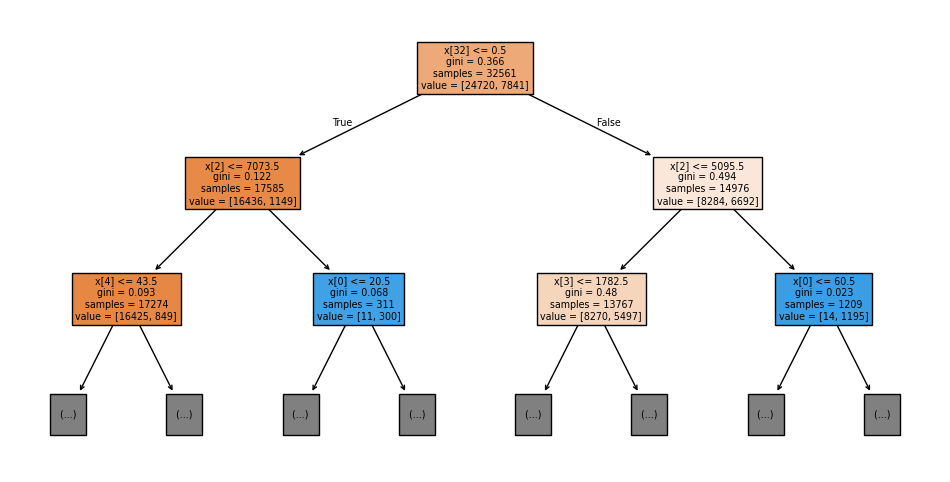

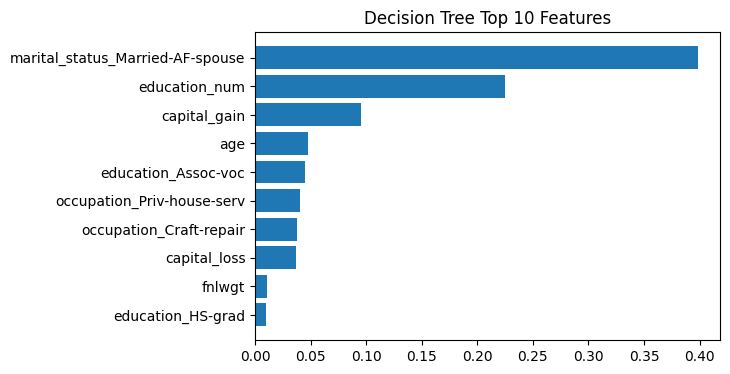

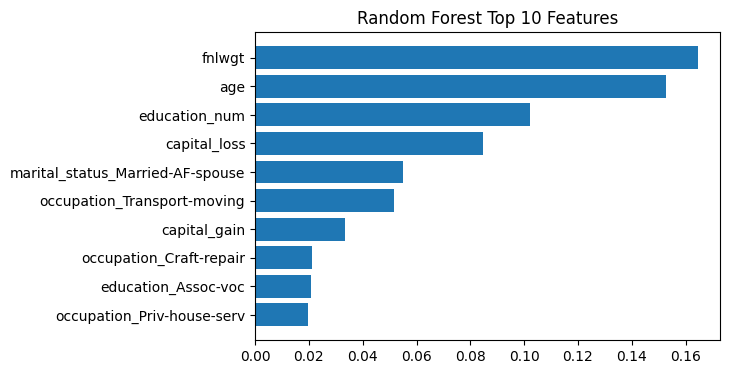

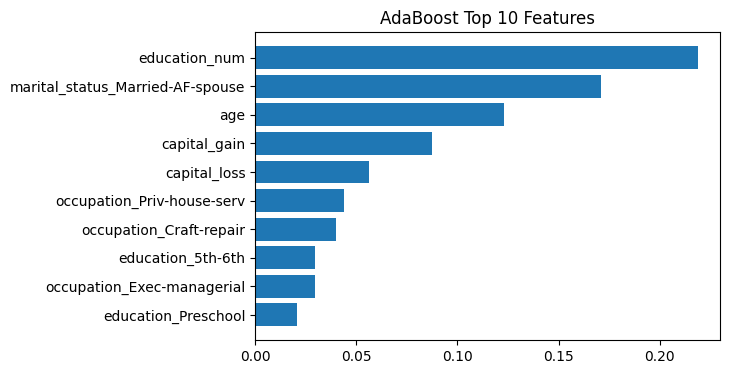

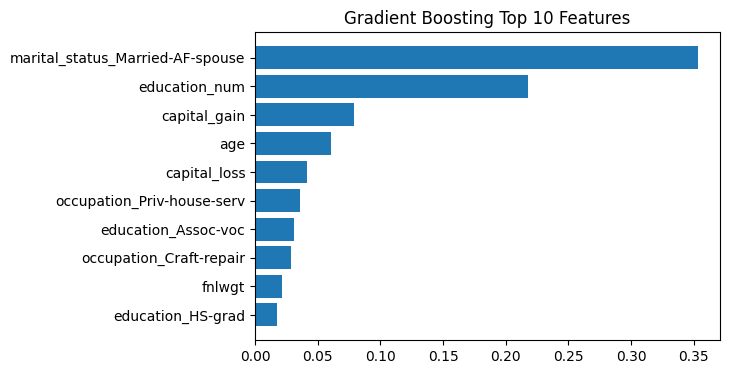

In [3]:
from sklearn.tree import plot_tree

# Plot shallow tree
dt = DecisionTreeClassifier(**results['DecisionTree']['best_params'], random_state=0)
dt.fit(X_train_full, y_train_full)
plt.figure(figsize=(12,6))
plot_tree(dt, max_depth=2, filled=True)
plt.show()

# Feature importances
def show_importances(model, name):
    imp = model.feature_importances_
    idx = np.argsort(imp)[-10:]
    names = list(train.select_dtypes(include=['int64','float64']).columns) + list(enc.get_feature_names_out())
    plt.figure(figsize=(6,4))
    plt.barh([names[i] for i in idx], imp[idx])
    plt.title(name + ' Top 10 Features')
    plt.show()

show_importances(dt, 'Decision Tree')
rf = RandomForestClassifier(**results['RandomForest']['best_params'], n_jobs=-1, random_state=0)
rf.fit(X_train_full, y_train_full)
show_importances(rf, 'Random Forest')
ab = AdaBoostClassifier(**results['AdaBoost']['best_params'], random_state=0)
ab.fit(X_train_full, y_train_full)
show_importances(ab, 'AdaBoost')
gb = GradientBoostingClassifier(**results['GradientBoosting']['best_params'], random_state=0)
gb.fit(X_train_full, y_train_full)
show_importances(gb, 'Gradient Boosting')

## 1.(b).i. Feedforward Neural Networks_Hyperparameters

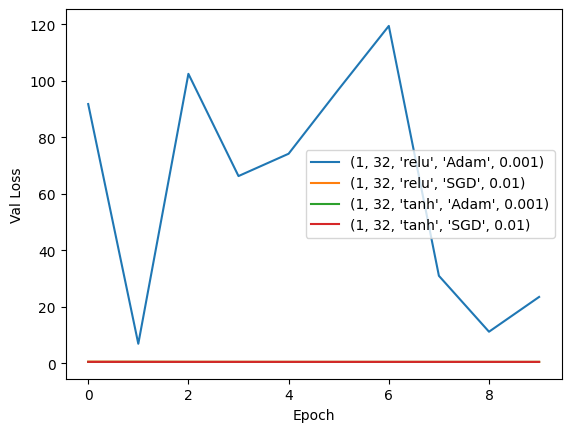

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD

# Build function now takes optimizer name and learning rate, creates fresh optimizer
def build_mlp(units, layers, activation, opt_name, lr):
    m = Sequential()
    m.add(tf.keras.Input(shape=(X_train.shape[1],)))
    m.add(Dense(units, activation=activation))
    for _ in range(layers-1):
        m.add(Dense(units, activation=activation))
    m.add(Dense(1, activation='sigmoid'))
    # Instantiate new optimizer
    if opt_name == 'Adam':
        optimizer = Adam(lr)
    else:
        optimizer = SGD(lr)
    m.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return m

# Configs: store opt name and lr, not instance
configs = []
for layers in [1,2]:
    for units in [32,64]:
        for act in ['relu','tanh']:
            configs.append((layers, units, act, 'Adam', 0.001))
            configs.append((layers, units, act, 'SGD', 0.01))
histories = {}
for cfg in configs:
    layers, units, act, opt_name, lr = cfg
    tf.random.set_seed(0)
    model = build_mlp(units, layers, act, opt_name, lr)
    hist = model.fit(
        X_train, y_train,
        epochs=10, batch_size=256,
        validation_data=(X_val, y_val),
        verbose=0
    )
    histories[cfg] = hist.history['val_loss']

# Plot example curves for first 4 configs
for cfg in list(histories)[:4]:
    plt.plot(histories[cfg], label=str(cfg))
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.legend()
plt.show()

## 1.(b).ii. Accuracy & Runtime

In [10]:
# Select best config based on lowest validation loss
best_cfg = min(histories, key=lambda c: min(histories[c]))
layers, units, act, opt_name, lr = best_cfg
# Build and train fresh model
start = time.time()
model = build_mlp(units, layers, act, opt_name, lr)
model.fit(
    X_train_full, y_train_full,
    epochs=20, batch_size=256,
    verbose=0
)
nn_time = time.time() - start
# Evaluate
nn_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Best NN config: {best_cfg}, Test Acc: {nn_acc:.4f}, Time: {nn_time:.1f}s")

Best NN config: (2, 64, 'tanh', 'Adam', 0.001), Test Acc: 0.7926, Time: 150.3s
